In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 3.2e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

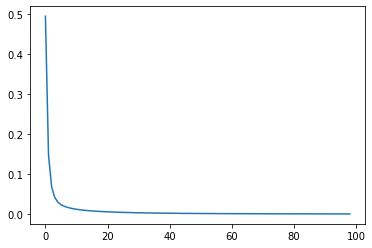

In [8]:
plt.plot(S)

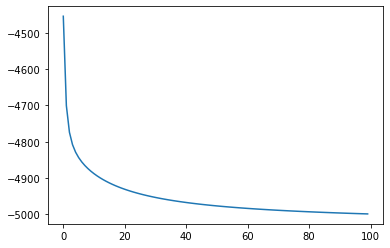

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0005215963064401876

In [11]:
eta

array([-4453.72939789, -4700.54545345, -4774.13837201, -4808.19633032,
       -4828.95184846, -4843.91710224, -4855.76087578, -4865.64514662,
       -4874.16563104, -4881.66748929, -4888.36993951, -4894.42232107,
       -4899.93205697, -4904.9797952 , -4909.62817467, -4913.9271898 ,
       -4917.91763101, -4921.63338189, -4925.10300711, -4928.35088413,
       -4931.3980314 , -4934.26272909, -4936.96099385, -4939.50694887,
       -4941.91311689, -4944.19065569, -4946.3495497 , -4948.39876771,
       -4950.34639404, -4952.19973854, -4953.96542957, -4955.64949331,
       -4957.25742165, -4958.79423073, -4960.26451174, -4961.67247509,
       -4963.02198911, -4964.31661395, -4965.55963153, -4966.75407197,
       -4967.90273708, -4969.0082212 , -4970.07292982, -4971.09909623,
       -4972.08879643, -4973.0439625 , -4973.96639468, -4974.85777225,
       -4975.71966329, -4976.55353365, -4977.36075492, -4978.14261181,
       -4978.90030877, -4979.63497606, -4980.34767525, -4981.03940432,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([5.45670603e+02, 2.98854547e+02, 2.25261629e+02, 1.91203670e+02,
       1.70448152e+02, 1.55482898e+02, 1.43639125e+02, 1.33754854e+02,
       1.25234370e+02, 1.17732511e+02, 1.11030061e+02, 1.04977679e+02,
       9.94679436e+01, 9.44202054e+01, 8.97718259e+01, 8.54728108e+01,
       8.14823695e+01, 7.77666187e+01, 7.42969934e+01, 7.10491164e+01,
       6.80019692e+01, 6.51372715e+01, 6.24390067e+01, 5.98930517e+01,
       5.74868837e+01, 5.52093449e+01, 5.30504509e+01, 5.10012329e+01,
       4.90536065e+01, 4.72002620e+01, 4.54345710e+01, 4.37505072e+01,
       4.21425789e+01, 4.06057698e+01, 3.91354888e+01, 3.77275255e+01,
       3.63780114e+01, 3.50833866e+01, 3.38403690e+01, 3.26459286e+01,
       3.14972635e+01, 3.03917794e+01, 2.93270707e+01, 2.83009043e+01,
       2.73112041e+01, 2.63560381e+01, 2.54336059e+01, 2.45422283e+01,
       2.36803373e+01, 2.28464669e+01, 2.20392456e+01, 2.12573888e+01,
       2.04996918e+01, 1.97650245e+01, 1.90523253e+01, 1.83605962e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_3.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_3.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_3.csv', S, delimiter = ',')